## Скрипт для скачивания OSISAF

In [7]:
import ftplib
import os
from pathlib import Path
import pandas as pd
from datetime import datetime

#ice_conc_nh_ease2-250_icdr-v3p0_202502071200.nc
def name_format(time: str, archive=True):
    #return f'ice_conc_nh_ease2-250_cdr-v3p1_{time}1200.nc'
    return f'ice_conc_nh_ease2-250_icdr-v3p0_{time}1200.nc'

def download(folder_to_save, file_name, ftp, silent=False):
    os.makedirs(folder_to_save, exist_ok=True)
    file_path = Path(folder_to_save, file_name)
    
    if file_path.exists():
        if not silent:
            print(f'{file_name} already exists')
        return True
            
    try:
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f'RETR {file_name}', f.write)
        if not silent:
            print(f'Downloaded: {file_name}')
        return True
    except Exception as e:
        if not silent:
            print(f'Error downloading {file_name}: {e}')
        if file_path.exists():
            file_path.unlink()
        return False

def download_pack(folder_to_save, start_day, end_day):
    # Проверяем, что даты не в будущем
    today = datetime.today().strftime('%Y%m%d')
    if end_day > today:
        print(f"Warning: End date {end_day} is in the future. Adjusting to today {today}")
        end_day = today
    
    dates = pd.date_range(start_day, end_day, freq='1D')
    remote_dir = 'reprocessed/ice/conc-cont-reproc/v3p0'
    
    # Создаем одно подключение для всех файлов
    with ftplib.FTP('osisaf.met.no') as ftp:
        ftp.login()
        print("Connected to FTP server")
        
        # Создаем словарь для кэширования проверенных директорий
        valid_dirs = {}
        
        for date in dates:
            year = date.strftime('%Y')
            month = date.strftime('%m')
            date_str = date.strftime('%Y%m%d')
            file_name = name_format(date_str)
            
            # Проверяем существование файла локально
            local_path = Path(folder_to_save, file_name)
            if local_path.exists():
                print(f'Skipping existing file: {file_name}')
                continue
                
            # Формируем путь на сервере
            remote_path = f"{remote_dir}/{year}/{month}"
            
            # Проверяем, была ли директория уже проверена
            if remote_path in valid_dirs:
                if valid_dirs[remote_path] is False:
                    print(f"Skipping known invalid directory: {remote_path}")
                    continue
            else:
                # Проверяем существование директории
                try:
                    # Используем команду CWD для проверки существования директории
                    ftp.cwd(remote_path)
                    valid_dirs[remote_path] = True
                    print(f"Directory valid: {remote_path}")
                except ftplib.error_perm as e:
                    print(f"Directory not found: {remote_path} ({str(e)})")
                    valid_dirs[remote_path] = False
                    continue
            
            try:
                # Получаем список файлов в директории
                file_list = ftp.nlst()
                if file_name not in file_list:
                    print(f"File not found on server: {file_name}")
                    continue
                
                # Скачиваем файл
                if download(folder_to_save, file_name, ftp, silent=False):
                    print(f"Successfully downloaded: {file_name}")
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
                continue

# Пример вызова с актуальными датами
folder_to_save = 'osisaf_data'
download_pack(folder_to_save, '20250201', '20250205') 

Connected to FTP server
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502011200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502021200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502041200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502051200.nc


## Скрипт для скачивания MASIE 

In [8]:
## import ftplib
import os
from pathlib import Path
import pandas as pd
from datetime import datetime, date

def day_of_year(year, month, day):
    date_obj = date(year, month, day)
    return '%03d' % date_obj.timetuple().tm_yday
    
#masie_all_r00_v01_2025001_4km.nc
def masie_name_format(date_str: str):
    #return f'masie_4km_ice_r00_v01_{date_str}.nc'
    return f'masie_all_r00_v01_{date_str}_1km.nc'


def download(folder_to_save, file_name, ftp, silent=False):
    os.makedirs(folder_to_save, exist_ok=True)
    file_path = Path(folder_to_save, file_name)
    
    if file_path.exists():
        if not silent:
            print(f'{file_name} already exists')
        return True
            
    try:
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f'RETR {file_name}', f.write)
        if not silent:
            print(f'Downloaded: {file_name}')
        return True
    except Exception as e:
        if not silent:
            print(f'Error downloading {file_name}: {e}')
        if file_path.exists():
            file_path.unlink()
        return False

def download_masie(folder_to_save, start_day, end_day):
    today = datetime.today().strftime('%Y%m%d')
    if end_day > today:
        print(f"Adjusting end date to today ({today})")
        end_day = today
    
    dates = pd.date_range(start_day, end_day, freq='1D')
    base_dir = '/DATASETS/NOAA/G02186/netcdf/1km'
    
    with ftplib.FTP('sidads.colorado.edu') as ftp:
        ftp.login()  # Анонимный вход
        print("Connected to NSIDC FTP server")
        
        valid_dirs_cache = {}
        
        for date in dates:
            
            year = date.strftime('%Y')
            month = date.strftime('%m')
            date_str = date.strftime('%Y%m%d')
            
            y, m, d = int(date_str[0:4]), int(date_str[4:6]), int(date_str[6:8]) 
            day_number = day_of_year(y, m, d)
            
            file_name = masie_name_format(f"{year}{day_number}")
            local_path = Path(folder_to_save, file_name)
            
            # Пропустить существующие файлы
            if local_path.exists():
                print(f'Skipping: {file_name}')
                continue
                
            # Формирование пути на сервере
            remote_dir = f"{base_dir}/{year}" #{day_number}" #/{month}"
            
            # Проверка директории в кэше
            if remote_dir in valid_dirs_cache:
                if not valid_dirs_cache[remote_dir]:
                    continue
            else:
                try:
                    ftp.cwd(remote_dir)
                    valid_dirs_cache[remote_dir] = True
                    print(f"Directory accessible: {remote_dir}")
                except ftplib.error_perm:
                    print(f"Directory not found: {remote_dir}")
                    valid_dirs_cache[remote_dir] = False
                    continue
            
            # Проверка наличия файла
            try:
                if file_name not in ftp.nlst():
                    print(f"File not available: {file_name}")
                    continue
                    
                download(folder_to_save, file_name, ftp)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

# Пример использования
folder_to_save = 'masie_data'
download_masie(folder_to_save, '20250201', '20250205')

Connected to NSIDC FTP server
Skipping: masie_all_r00_v01_2025032_1km.nc
Skipping: masie_all_r00_v01_2025033_1km.nc
Skipping: masie_all_r00_v01_2025034_1km.nc
Skipping: masie_all_r00_v01_2025035_1km.nc
Skipping: masie_all_r00_v01_2025036_1km.nc


## Plot files

Рисовать буду за 03.02.2025
Снимки:
1. osisaf
2. masie
3. Geotiff (оптика)
4. Гибридный снимок

tutor plot: https://medium.com/@Manjar-Alam/clipping-and-visualizing-netcdf-data-using-python-84dfbbbce0a5

In [53]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import cmocean as cm
import rioxarray as rxr
import numpy as np

In [54]:
# Используем общую проекцию для всех графиков
proj_common = ccrs.NorthPolarStereo(central_longitude=-45)

# Загрузка и подготовка спутникового снимка
sar_file = '/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/snapshot-2025-02-03T00_00_00Z.tif'
sar_da = rxr.open_rasterio(sar_file).squeeze()
sar_proj = sar_da.rio.reproject(proj_common)
extent = [sar_proj.x.min().item(), sar_proj.x.max().item(), 
          sar_proj.y.min().item(), sar_proj.y.max().item()]

In [55]:
sar_proj

<xarray.DataArray (band: 4, y: 5948, x: 4352)> Size: 104MB
array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]],
      shape=(4, 5948, 4352), dtype=uint8)
Coordinates:
  * x            (x) float64 35kB -6.087e+05 -6.086e+05 ... -3.546e+05
  * y            (y) float64 48kB 4.911e+06 4.911e+06 ... 4.563e+06 4.563e+06
  * band         (band) int64 32B 1 2 3 4
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              255

In [59]:
ds_masie = xr.open_dataset('/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/masie_data/masie_all_r00_v01_2025034_1km.nc') #.squeeze()

### Репроекция и срез снимка osisaf на tiff 

In [101]:
ds_osisaf = xr.open_dataset('/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/osisaf_data/ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc')

In [102]:
ds_osisaf['xc'] = ds_osisaf['xc'] * 1000
ds_osisaf['yc'] = ds_osisaf['yc'] * 1000
ds_osisaf = ds_osisaf.rename({'xc': 'x', 'yc': 'y'})

In [103]:
#ds_osisaf = ds_osisaf.rio.write_crs(ds_osisaf['Lambert_Azimuthal_Grid'].attrs['crs_wkt'], inplace=True)
ds_osisaf = ds_osisaf.rio.write_crs(ds_osisaf['Lambert_Azimuthal_Grid'].attrs['proj4_string'], inplace=True)


In [116]:
ds_osisaf_rep = ds_osisaf['ice_conc'].rio.reproject_match(sar_proj, Resampling='gauss000')

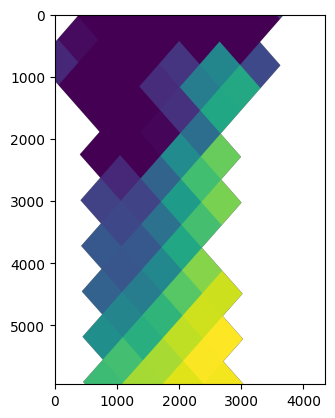

In [115]:
plt.imshow(ds_osisaf_rep.values[0,:,:])

In [174]:
'''
#ds_osisaf = ds_osisaf.rename({'lon': 'x', 'lat': 'y'})
#ds_osisaf = ds_osisaf.rio.write_crs(ds_osisaf['Lambert_Azimuthal_Grid'].attrs['crs_wkt'], inplace=True)

ds_osisaf = ds_osisaf.rio.write_crs(ds_osisaf['Lambert_Azimuthal_Grid'].attrs['crs_wkt'], inplace=True)

#ds_osisaf.rio.set_spatial_dims('X', 'Y')
ds_osisaf_rep = ds_osisaf['ice_conc'].rio.reproject_match(sar_proj)
'''

In [179]:
ds_osisaf['Lambert_Azimuthal_Grid'].attrs

{'crs_wkt': 'PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'unknown',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'unknown',
 'grid_mapping_name': 'lambert_azimuthal_equal_area',
 'latitude_of_projection_origin': 90.0,
 'longitude_of_projection_origin': 0

In [147]:
ds_osisaf['Lambert_Azimuthal_Grid'].attrs['proj4_string']

'+proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=90.0'

In [39]:
ds_osisaf_rep

<xarray.DataArray 'ice_conc' (time: 1, y: 5948, x: 4352)> Size: 207MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(1, 5948, 4352))
Coordinates:
  * time                    (time) datetime64[ns] 8B 2025-02-03T12:00:00
    Lambert_Azimuthal_Grid  int64 8B 0
  * x                       (x) float64 35kB -6.087e+05 ... -3.546e+05
  * y                       (y) float64 48kB 4.911e+06 4.911e+06 ... 4.563e+06
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    ancillary_variables:  total_standard_uncertainty status_flag
    comment:              this field is the primary sea ice concentration est...

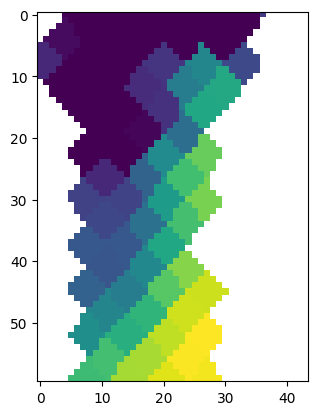

In [110]:
plt.imshow(ds_osisaf_rep.isel(x=slice(None, None, 100), 
                          y=slice(None, None, 100)).values[0,:,:])

In [43]:
ds_osisaf_rep

<xarray.DataArray 'ice_conc' (time: 1, y: 5948, x: 4352)> Size: 207MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(1, 5948, 4352))
Coordinates:
  * time                    (time) datetime64[ns] 8B 2025-02-03T12:00:00
    Lambert_Azimuthal_Grid  int64 8B 0
  * x                       (x) float64 35kB -6.087e+05 ... -3.546e+05
  * y                       (y) float64 48kB 4.911e+06 4.911e+06 ... 4.563e+06
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    ancillary_variables:  total_standard_uncertainty status_flag
    comment:              this field is the primary sea ice concentration est...

In [150]:
#ds_osisaf['Lambert_Azimuthal_Grid'].attrs['crs_wkt']
#ds_osisaf.rename_dims('')
ds_osisaf = ds_osisaf.rename_dims({"xc": "x", "yc": "y"})

In [112]:
# ds_osisaf['Lambert_Azimuthal_Grid'].attrs['crs_wkt']
ds_osisaf.attrs['geospatial_bounds_crs']
#ds_osisaf.

'EPSG:6931'

In [25]:
plt.imshow(ds_osisaf_rep["sea_ice_extent"][0, :, :])

KeyError: 'sea_ice_extent'

In [22]:
ds_osisaf_rep

<xarray.Dataset> Size: 104MB
Dimensions:              (time: 1, x: 4352, y: 5948)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2025-02-03
    polar_stereographic  int64 8B 0
  * x                    (x) float64 35kB -6.087e+05 -6.086e+05 ... -3.546e+05
  * y                    (y) float64 48kB 4.911e+06 4.911e+06 ... 4.563e+06
Data variables:
    sea_ice_extent       (time, y, x) float32 104MB 2.0 2.0 2.0 ... 2.0 2.0 2.0
Attributes: (12/52)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      Multisensor Analyzed Sea Ice Extent - Norther...
    creator_name:               National Snow and Ice Data Center
    creator_email:              nsidc@nsidc.org
    creator_url:                https://nsidc.org/
    institution:                National Snow and Ice Data Center
    ...                         ...
    date_created:               2025-02-04T20:01:35Z
    history:                    04 February 2025 20:01Z: NetCDF file generate...
    time_coverage_start:        2025-02-03T00:00:00Z
    time_coverage_end:          2025-02-03T23:59:59Z
    geospatial_bounds_crs:      PROJCS["Stereographic_North_Pole",GEOGCS["WGS...
    geospatial_bounds:          POLYGON ((12288000.0000000000000000 -12288000...

### Репроекция и срез снимка masie на tiff 

In [63]:
sar_da_raw = rxr.open_rasterio(sar_file)
ds_masie = ds_masie.rio.write_crs(ds_masie.attrs['geospatial_bounds_crs'], inplace=True)
# ds_masie_rep = ds_masie.rio.reproject_(proj_common)
ds_masie_rep = ds_masie.rio.reproject_match(sar_proj)

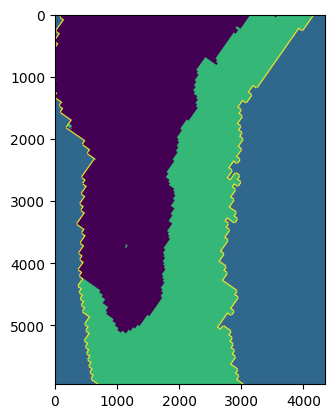

In [64]:
# plt.imshow(data_sub[0, :, :])
plt.imshow(ds_masie_rep["sea_ice_extent"][0, :, :])

In [19]:
ds_osisaf_rep

<xarray.DataArray 'ice_conc' (y: 1, x: 1)> Size: 8B
array([[nan]])
Coordinates:
    time                    datetime64[ns] 8B 2025-02-03T12:00:00
    Lambert_Azimuthal_Grid  int64 8B 0
  * x                       (x) float64 8B -6.087e+05
  * y                       (y) float64 8B 4.911e+06
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    ancillary_variables:  total_standard_uncertainty status_flag
    comment:              this field is the primary sea ice concentration est...

In [24]:
plt.imshow(ds_sub_osisaf.values)

NameError: name 'ds_sub_osisaf' is not defined

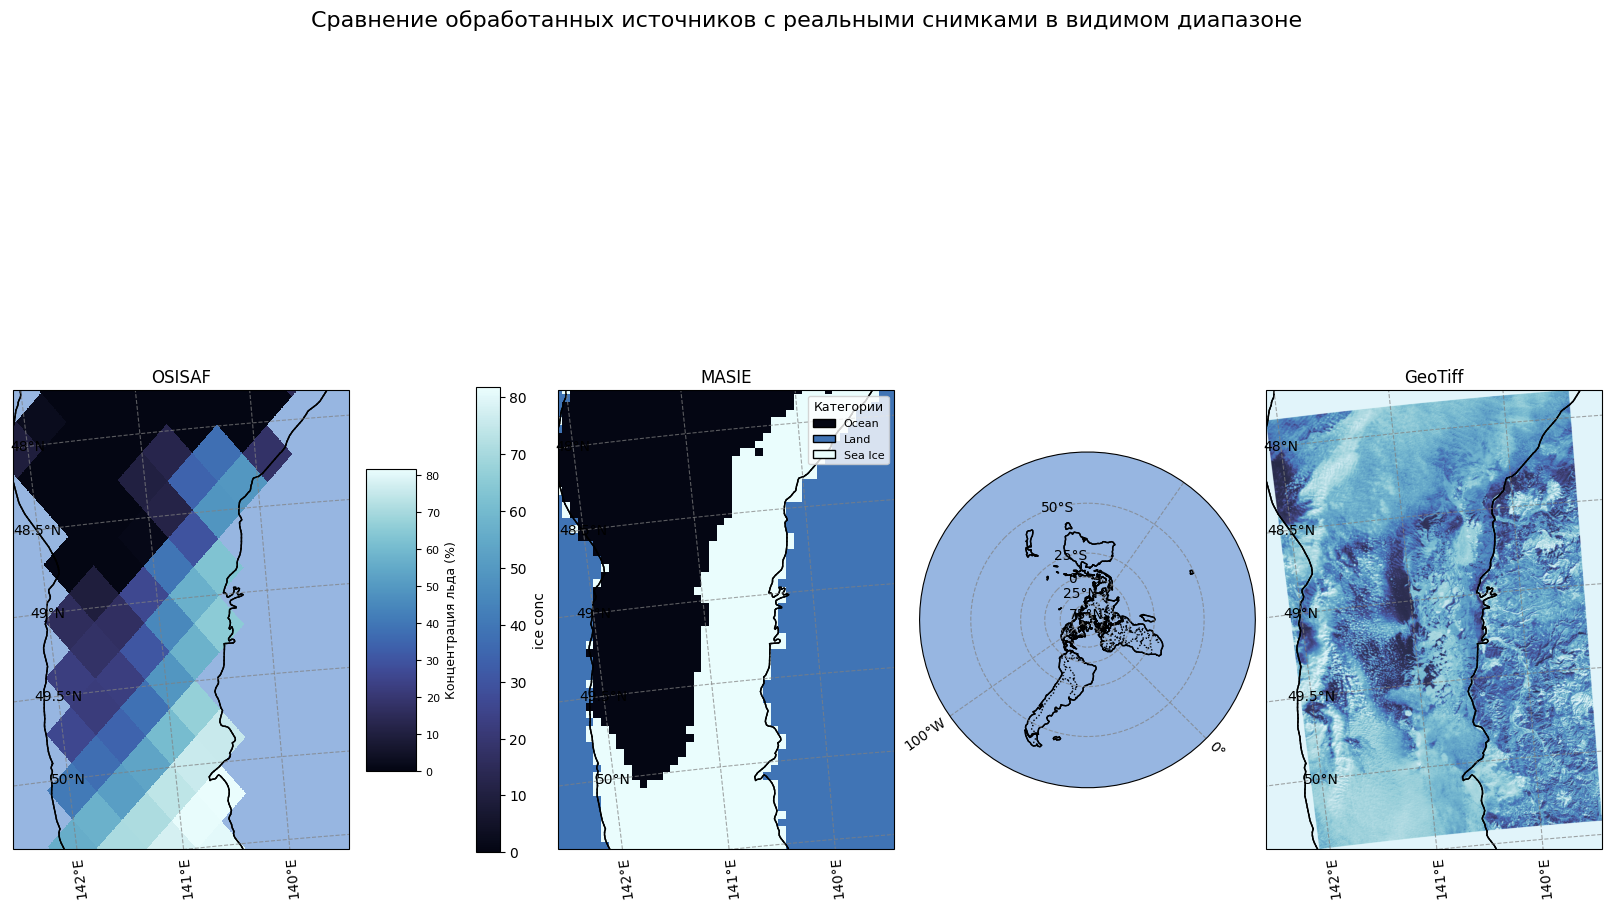

In [118]:
# Создаем фигуру с разными проекциями для последнего subplot
fig = plt.figure(figsize=(16, 12), layout="constrained")


subsample = 100

# Создаем оси в общей проекции
ax0 = fig.add_subplot(1, 4, 1, projection=proj_common)
ax1 = fig.add_subplot(1, 4, 2, projection=proj_common)
ax2 = fig.add_subplot(1, 4, 3, projection=proj_common)
ax3 = fig.add_subplot(1, 4, 4, projection=proj_common)

axs = [ax0, ax1, ax2, ax3]

# Функция добавления координатной сетки
def add_gridlines(ax):
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    gl.xlocator = plt.MaxNLocator(nbins=4)
    gl.ylocator = plt.MaxNLocator(nbins=6)

# Добавляем побережья и сетку для всех осей
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    add_gridlines(ax)
    


# ========================
# 1. Plot OSISAF с компактной шкалой
# ========================

ds_osisaf_sub_rep = ds_osisaf_rep.isel(x=slice(None, None, 5), 
                          y=slice(None, None, 5))

mesh_osisaf = axs[0].pcolormesh(
    ds_osisaf_sub_rep['x'].values, 
    ds_osisaf_sub_rep['y'].values, 
    ds_osisaf_sub_rep.values[0,:,:],
    cmap=cm.cm.ice, 
    transform=proj_common
)
cbar_osisaf = plt.colorbar(mesh_osisaf, ax=axs[0], orientation='vertical', pad=0.05, shrink=0.4)
cbar_osisaf.set_label('ice conc')
axs[0].set_extent(extent, crs=proj_common)
axs[0].set_title('OSISAF')

# Компактная шкала для OSISAF
cbar_osisaf = plt.colorbar(mesh_osisaf, ax=axs[0], shrink=0.6, aspect=6)
cbar_osisaf.set_label('Концентрация льда (%)', fontsize=9)
cbar_osisaf.ax.tick_params(labelsize=8)  # Уменьшаем размер меток

# ========================
# 2. Plot MASIE с компактной шкалой
# ========================

# Подвыборка данных
ds_sub_masie = ds_masie_rep.isel(time=0, 
                          x=slice(None, None, subsample), 
                          y=slice(None, None, subsample))

# Получаем цвета из cm.cm.ice
color_ocean = cm.cm.ice(0.0)     # Цвет для океана (0% льда)
color_land = cm.cm.ice(0.48)     # Цвет для земли
color_ice = cm.cm.ice(1.0)       # Цвет для льда (100% концентрация)

# Создаем дискретную цветовую карту
colors = [color_ocean, color_land, color_ice]
cmap_masie = ListedColormap(colors)

# Устанавливаем границы категорий
bounds = [0.5, 1.5, 2.5, 3.5]
norm_masie = BoundaryNorm(bounds, cmap_masie.N)

# Визуализация MASIE
mesh_masie = axs[1].pcolormesh(
    ds_sub_masie['x'].values,
    ds_sub_masie['y'].values,
    ds_sub_masie['sea_ice_extent'].values,
    cmap=cmap_masie,
    norm=norm_masie,
    transform=proj_common
)

axs[1].set_extent(extent, crs=proj_common)
axs[1].set_title('MASIE')

from matplotlib.patches import Patch

legend_labels = ['Ocean', 'Land', 'Sea Ice']
legend_colors = [color_ocean, color_land, color_ice]

# Создаем кастомные патчи
legend_elements = [
    Patch(facecolor=color, edgecolor='k', label=label) 
    for color, label in zip(legend_colors, legend_labels)
]

# Размещаем легенду в нужном месте (loc - позиция)
axs[1].legend(
    handles=legend_elements,
    loc='best',           # Автовыбор позиции (можно заменить на 'upper right' и т.д.)
    frameon=True,         # Рамка вокруг легенды
    fontsize=8,           # Размер шрифта
    title='Категории',    # Заголовок легенды
    title_fontsize=9      # Размер шрифта заголовка
)

# ========================
# 3. Plot satellite images
# ========================

sar_img = sar_proj.values[0] if len(sar_proj.shape) == 3 else sar_proj.values
axs[3].imshow(
    sar_img,
    extent=extent,
    cmap=cm.cm.ice,
    origin='upper',
    zorder=1,
    alpha=0.9
)
axs[3].set_title('GeoTiff')

# Заголовок
fig.suptitle('Сравнение обработанных источников с реальными снимками в видимом диапазоне', fontsize=16)

plt.show()

In [70]:
from rasterio.warp import reproject, Resampling

In [ ]:
Resampling.cubic_spline

In [69]:
help(ds_osisaf_sub_rep.rio.reproject_match)

Help on method reproject_match in module rioxarray.raster_array:

reproject_match(
    match_data_array: Union[xarray.core.dataarray.DataArray, xarray.core.dataset.Dataset],
    *,
    resampling: rasterio.enums.Resampling = <Resampling.nearest: 0>,
    **reproject_kwargs
) -> xarray.core.dataarray.DataArray method of rioxarray.raster_array.RasterArray instance
    Reproject a DataArray object to match the resolution, projection,
    and region of another DataArray.

    Powered by :func:`rasterio.warp.reproject`

    .. note:: Only 2D/3D arrays with dimensions 'x'/'y' are currently supported.
        Requires either a grid mapping variable with 'spatial_ref' or
        a 'crs' attribute to be set containing a valid CRS.
        If using a WKT (e.g. from spatiareference.org), make sure it is an OGC WKT.

    .. versionadded:: 0.9 reproject_kwargs

    Parameters
    ----------
    match_data_array:  :obj:`xarray.DataArray` | :obj:`xarray.Dataset`
        DataArray of the target resolut

In [67]:
ds_osisaf_sub_rep

<xarray.DataArray 'ice_conc' (time: 1, y: 60, x: 44)> Size: 21kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(1, 60, 44))
Coordinates:
  * time                    (time) datetime64[ns] 8B 2025-02-03T12:00:00
    Lambert_Azimuthal_Grid  int64 8B 0
  * x                       (x) float64 352B -6.087e+05 ... -3.576e+05
  * y                       (y) float64 480B 4.911e+06 4.905e+06 ... 4.566e+06
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    ancillary_variables:  total_standard_uncertainty status_flag
    comment:              this field is the primary sea ice concentration est...

In [56]:
ds_masie_rep['sea_ice_extent'].values[0,:,:]

array([[2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       ...,
       [3., 3., 3., ..., 4., 4., 4.],
       [3., 3., 3., ..., 4., 4., 4.],
       [3., 3., 3., ..., 4., 4., 4.]], shape=(4697, 4873), dtype=float32)

In [64]:
ds_masie_rep

<xarray.Dataset> Size: 92MB
Dimensions:              (time: 1, x: 4873, y: 4697)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2025-02-03
    polar_stereographic  int64 8B 0
  * x                    (x) float64 39kB 139.4 139.4 139.4 ... 142.1 142.1
  * y                    (y) float64 38kB 50.42 50.42 50.42 ... 47.84 47.84
Data variables:
    sea_ice_extent       (time, y, x) float32 92MB 2.0 2.0 2.0 ... 4.0 4.0 4.0
Attributes: (12/52)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      Multisensor Analyzed Sea Ice Extent - Norther...
    creator_name:               National Snow and Ice Data Center
    creator_email:              nsidc@nsidc.org
    creator_url:                https://nsidc.org/
    institution:                National Snow and Ice Data Center
    ...                         ...
    date_created:               2025-02-04T20:01:35Z
    history:                    04 February 2025 20:01Z: NetCDF file generate...
    time_coverage_start:        2025-02-03T00:00:00Z
    time_coverage_end:          2025-02-03T23:59:59Z
    geospatial_bounds_crs:      PROJCS["Stereographic_North_Pole",GEOGCS["WGS...
    geospatial_bounds:          POLYGON ((12288000.0000000000000000 -12288000...

In [11]:
print("X range:", ds_masie.x.min().item(), "to", ds_masie.x.max().item())
print("Y range:", ds_masie.y.min().item(), "to", ds_masie.y.max().item())
print("Указанный диапазон X:", x_min, "to", x_max)
print("Указанный диапазон Y:", y_min, "to", y_max)

X range: -12287500.0 to 12287500.0
Y range: -12287500.0 to 12287500.0
Указанный диапазон X: -12287500.0 to 12287500.0
Указанный диапазон Y: -12287500.0 to 12287500.0


In [12]:
#dF10r=dF10[(dF10.lat>minlat)&(dF10.lat<maxlat)]
y_min = 3246839 
x_min = -3086603
y_max = 3530621
x_max = -2850255
# ds_masie_cut = ds_masie.where((ds_masie.x < x_max) & (ds_masie.x > x_min) & (ds_masie.y < y_max) & (ds_masie.y > y_min))
import numpy as np

# Находим индексы в диапазоне
x_idx = np.where(
    (ds_masie.x.values >= x_min) & 
    (ds_masie.x.values <= x_max)
)[0]

y_idx = np.where(
    (ds_masie.y.values >= y_min) & 
    (ds_masie.y.values <= y_max)
)[0]

# Обрезаем по индексам
if len(x_idx) > 0 and len(y_idx) > 0:
    ds_masie_cut = ds_masie.isel(
        x= slice(x_idx.min(), x_idx.max()),
        y=slice(y_idx.min(), y_idx.max())
    )
else:
    print("Ошибка: Нет данных в указанном диапазоне")
    ds_masie_cut = ds_masie  # Возвращаем оригинал для отладки
ds_masie_cut

<xarray.Dataset> Size: 271kB
Dimensions:              (time: 1, x: 236, y: 283)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2025-02-03
  * x                    (x) float64 2kB -3.086e+06 -3.086e+06 ... -2.852e+06
    y                    (x) float64 2kB -3.086e+06 -3.086e+06 ... -2.852e+06
Data variables:
    polar_stereographic  |S1 1B ...
    sea_ice_extent       (time, y, x) float32 267kB ...
Attributes: (12/52)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      Multisensor Analyzed Sea Ice Extent - Norther...
    creator_name:               National Snow and Ice Data Center
    creator_email:              nsidc@nsidc.org
    creator_url:                https://nsidc.org/
    institution:                National Snow and Ice Data Center
    ...                         ...
    date_created:               2025-02-04T20:01:35Z
    history:                    04 February 2025 20:01Z: NetCDF file generate...
    time_coverage_start:        2025-02-03T00:00:00Z
    time_coverage_end:          2025-02-03T23:59:59Z
    geospatial_bounds_crs:      PROJCS["Stereographic_North_Pole",GEOGCS["WGS...
    geospatial_bounds:          POLYGON ((12288000.0000000000000000 -12288000...

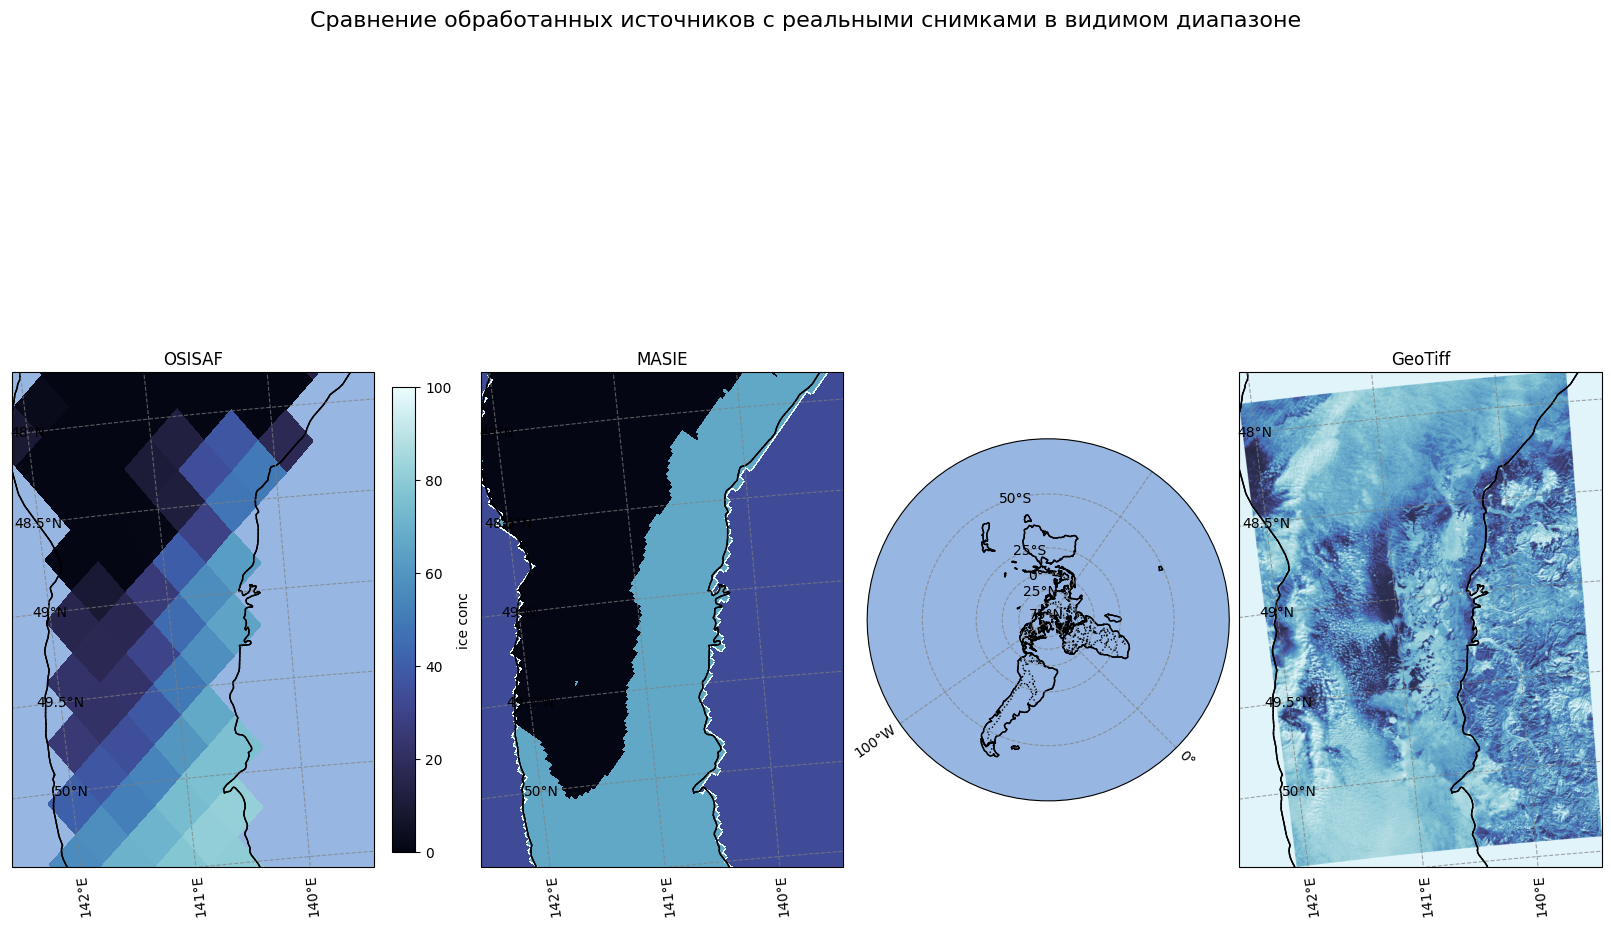

In [30]:
# Создаем фигуру с разными проекциями для последнего subplot
fig = plt.figure(figsize=(16, 12), layout="constrained")


# Создаем оси в общей проекции
ax0 = fig.add_subplot(1, 4, 1, projection=proj_common)
ax1 = fig.add_subplot(1, 4, 2, projection=proj_common)
ax2 = fig.add_subplot(1, 4, 3, projection=proj_common)
ax3 = fig.add_subplot(1, 4, 4, projection=proj_common)

axs = [ax0, ax1, ax2, ax3]

# Функция добавления координатной сетки
def add_gridlines(ax):
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    gl.xlocator = plt.MaxNLocator(nbins=4)
    gl.ylocator = plt.MaxNLocator(nbins=6)

# Добавляем побережья и сетку для всех осей
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    add_gridlines(ax)
    


# ========================
# 1. Plot OSISAF
# ========================
mesh_osisaf = axs[0].pcolormesh(
    ds_osisaf['lon'].values, 
    ds_osisaf['lat'].values, 
    ds_osisaf['ice_conc'].values[0,:,:], 
    cmap=cm.cm.ice, 
    transform=ccrs.PlateCarree()
)
cbar_osisaf = plt.colorbar(mesh_osisaf, ax=axs[0], orientation='vertical', pad=0.05, shrink=0.4)
cbar_osisaf.set_label('ice conc')
axs[0].set_extent(extent, crs=proj_common)
axs[0].set_title('OSISAF')

# ========================
# 2. Plot MASIE
# ========================
# Подвыборка данных
subsample = 100
ds_sub = ds_masie_rep.isel(time=0, x=slice(None, None, subsample), 
                      y=slice(None, None, subsample))

# Визуализация MASIE
mesh_masie = axs[1].pcolormesh(
    ds_masie_rep['x'].values,
    ds_masie_rep['y'].values,
    ds_masie_rep['sea_ice_extent'].values[0,:,:],
    transform=proj_common,  # Используем общую проекцию
    cmap=cm.cm.ice
)


axs[1].set_extent(extent, crs=proj_common)  # Исправлено: set_extent для axs[1]
axs[1].set_title('MASIE')


# ========================
# 3. Plot satellite images
# ========================
sar_img = sar_proj.values[0] if len(sar_proj.shape) == 3 else sar_proj.values
axs[3].imshow(
    sar_img,
    extent=extent,
    cmap=cm.cm.ice,
    origin='upper',
    zorder=1,
    alpha=0.9
)
axs[3].set_title('GeoTiff')

# Заголовок
fig.suptitle('Сравнение обработанных источников с реальными снимками в видимом диапазоне', fontsize=16)

plt.show()